In [1]:
# imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
import os

## Load data

In [137]:
# load data
root = os.getcwd()
dataset_dir = os.path.join(root, 'Data_60')

In [135]:
raw_df = pd.DataFrame()

# Raw dataframe

Fun


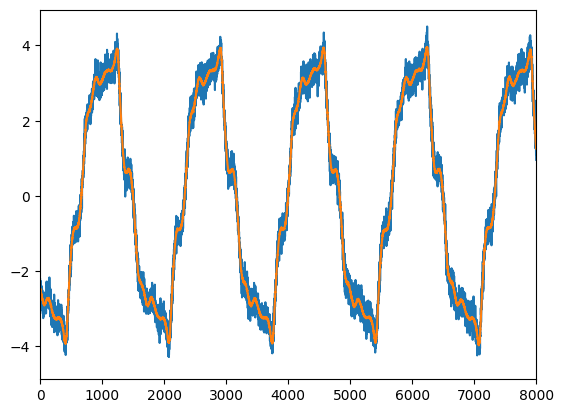

HairDryer
Heater
LightBulb
Refrigerator


,label,time_sig
count,300,300
unique,5,300
top,Fun,"[-2.2116957480896033, -2.7087162004571788, -2...."
freq,60,1


In [400]:
# Initialize an empty list to store data
data_list = []

list_of_folders = os.listdir(dataset_dir)

fs  = 1/100000 #Hz
n_harmonics = 200
noise = 0.2

first_iter = True
# Read matlab files
for folder in list_of_folders:
    path = os.path.join(dataset_dir, folder)
    list_of_files = os.listdir(path)
    label = str(folder)
    print(label)
    for file in list_of_files:
        if file.endswith('.mat'):
            # Read matlab file
            mat = scipy.io.loadmat(os.path.join(path, file))

            # Get data and append to the list
            t_sig = mat['tpd']['Data'][0][0][0] + np.random.normal(0, noise, len(mat['tpd']['Data'][0][0][0]))
            # ft =np.fft.fft(t_sig)
            if first_iter:
                freqs = np.fft.fftfreq(len(t_sig), fs)
                #h_index = np.where(freqs % 60 == 0)[0]
                #print("harmonics indicies", h_index)


                plt.figure()
                plt.plot(t_sig)
                plt.plot(mat['tpd']['Data'][0][0][0])
                plt.xlim(0, 8000)
                plt.show()

                
                # fc_low = 57
                # fc_high = 63
                # w = np.zeros(len(freqs))
                # w[np.where(fc_high<freqs)] = 1
                # w[np.where(freqs<fc_low)] = 1
                first_iter = False
            # ft_cut =  ft*w
            # abs_ft_cut_norm = abs(ft_cut/np.linalg.norm(ft_cut)) + 1e-10
            
            # harmo = np.log(abs_ft_cut_norm[h_index][2:n_harmonics] + 1e-10)
            # pick_afftn = abs_ft_cut_norm[np.argsort(abs_ft_cut_norm)[0:30]]
            data_list.append({'label': label, 
                              'time_sig': t_sig})

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)

# Display DataFrame description
df.describe()

(0.0, 3000.0)

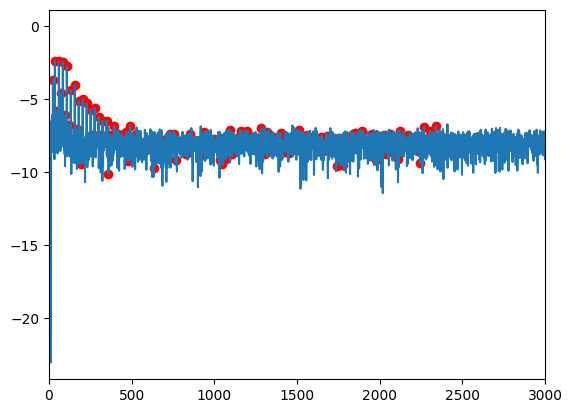

In [369]:
plt.plot(df['full_fft'][0])
plt.scatter(h_index[2:n_harmonics], df['harmonics'][0], c='r')
plt.xlim(0,3000)

## Filter 60Hz


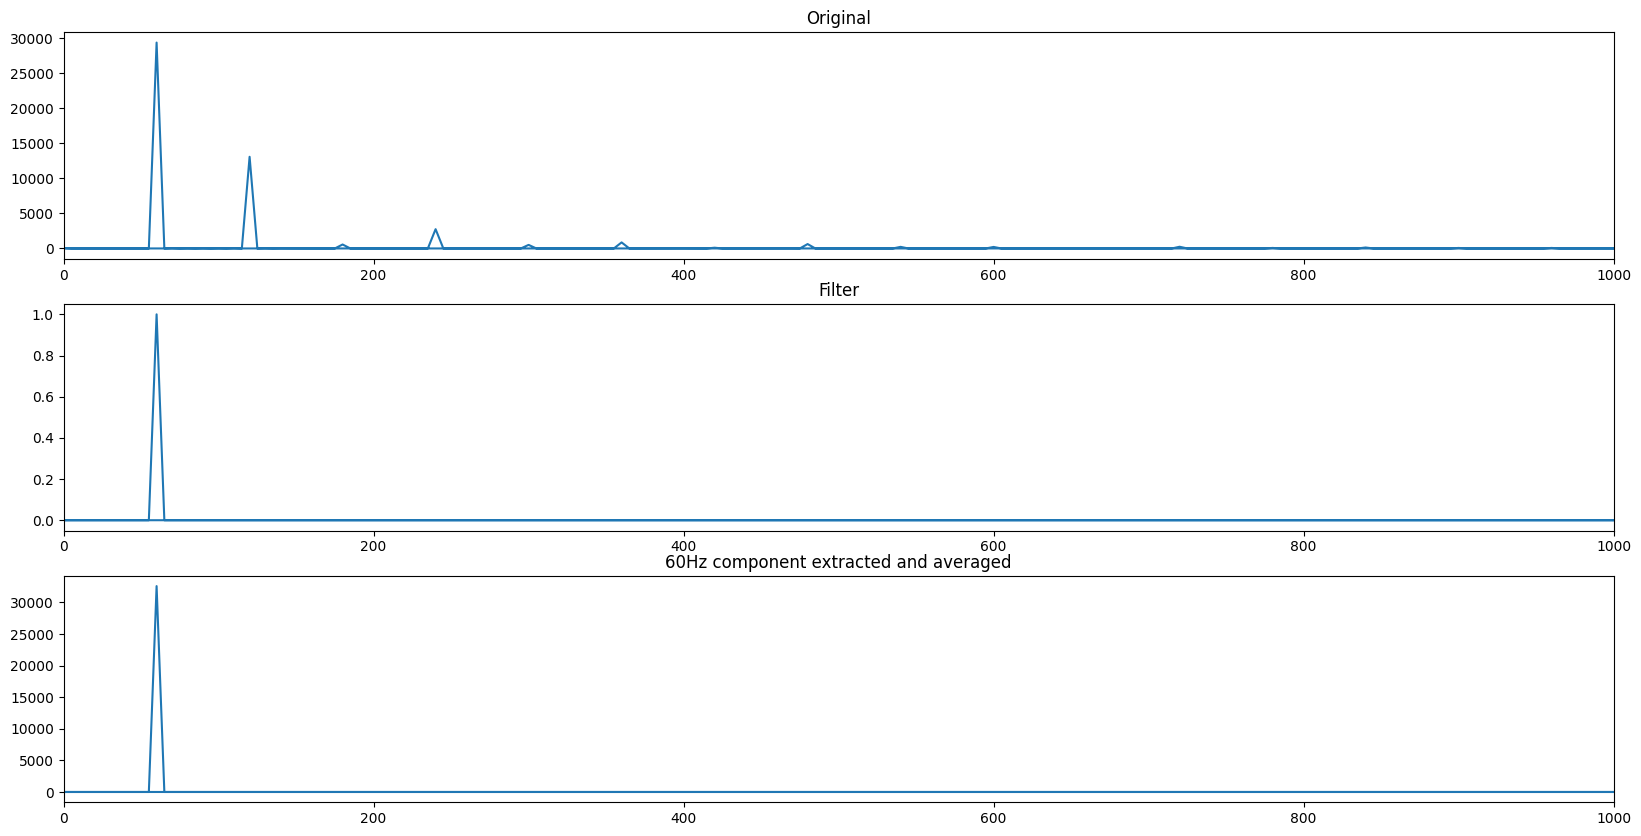

In [ ]:
# cut 60Hz
w= np.zeros(len(df['fft'][0]))
fs  = 1/100000 #Hz
freqs = np.fft.fftfreq(len(df['fft'][0]), fs)
fc_low = 59
fc_high = 61
w[np.where(fc_high<freqs)] = 1
w[np.where(freqs<fc_low)] = 1
w_sin = 1-w
avg_sin = abs(df['fft'].apply(lambda x: x*w_sin)).mean()

plt.figure(figsize=(20, 10))
plt.subplot(3,1,3)
plt.plot(freqs, avg_sin)
plt.title('60Hz component extracted and averaged')
plt.xlim(0, 1000)
plt.subplot(3,1,1)
plt.plot(freqs, abs(df['fft'][33]))
plt.title('Original')
plt.xlim(0, 1000)
plt.subplot(3,1,2)
plt.plot(freqs, w_sin)
plt.xlim(0, 1000)
plt.title('Filter')
plt.show()


C:\Users\alexi\AppData\Local\Temp\ipykernel_38584\2396251472.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(freqs, np.log(abs(df['fft_cut'][30])))


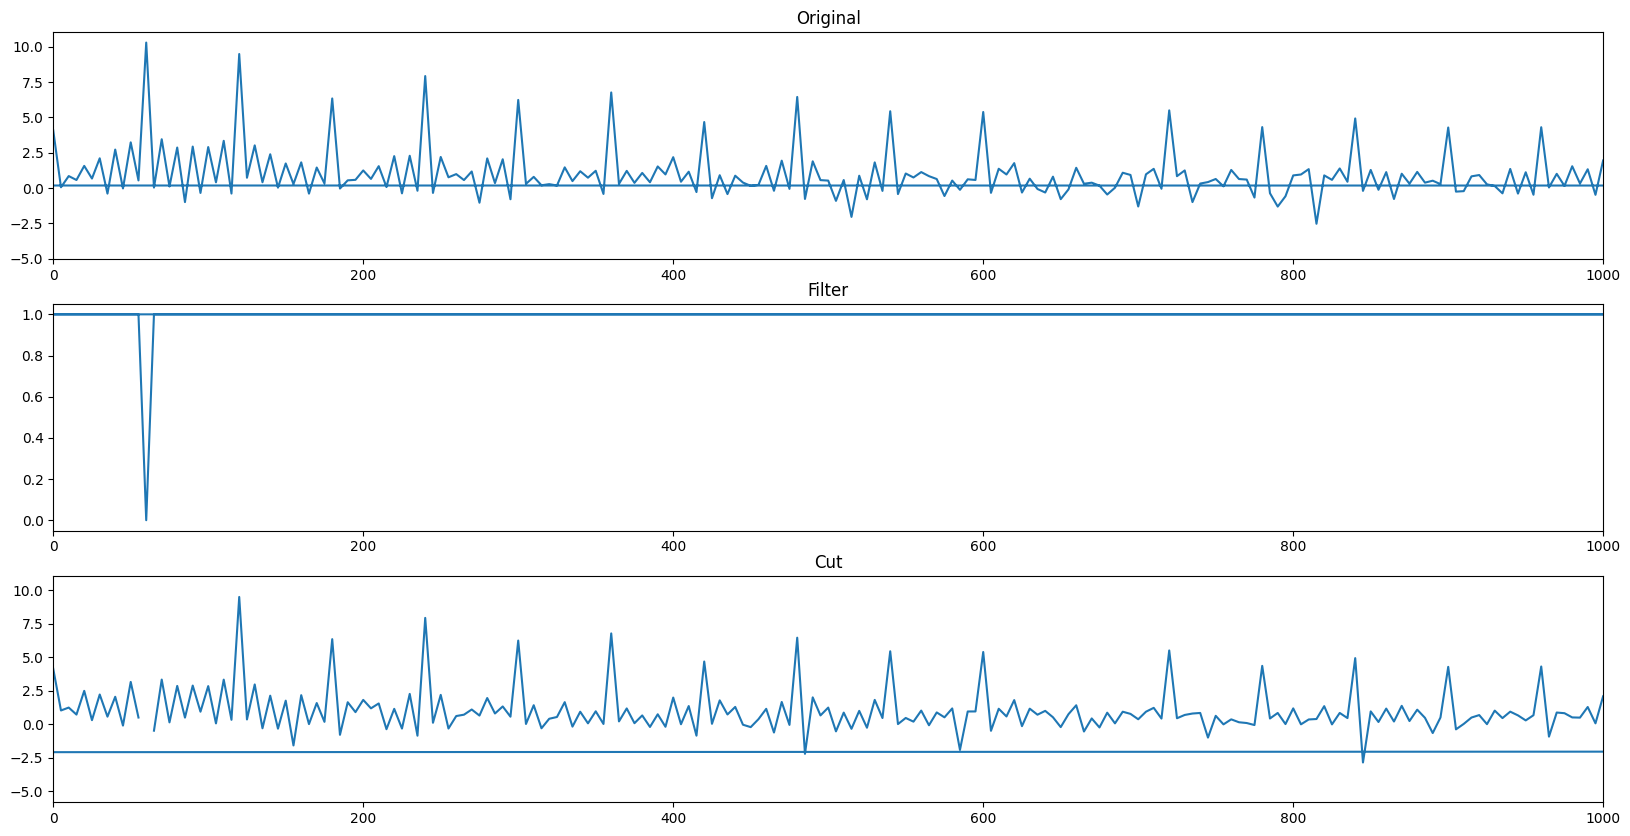

In [71]:
# cut 60Hz
w= np.zeros(len(df['fft'][0]))
fs  = 1/100000 #Hz
freqs = np.fft.fftfreq(len(df['fft'][0]), fs)
fc_low = 59
fc_high = 61
w[np.where(fc_high<freqs)] = 1
w[np.where(freqs<fc_low)] = 1
df['fft_cut'] = df['fft'].apply(lambda x: x*w)

plt.figure(figsize=(20, 10))
plt.subplot(3,1,3)
plt.plot(freqs, np.log(abs(df['fft_cut'][30])))
plt.title('Cut')
plt.xlim(0, 1000)
plt.subplot(3,1,1)
plt.plot(freqs, np.log(abs(df['fft'][33])))
plt.title('Original')
plt.xlim(0, 1000)
plt.subplot(3,1,2)
plt.plot(freqs, w)
plt.xlim(0, 1000)
plt.title('Filter')
plt.show()


C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


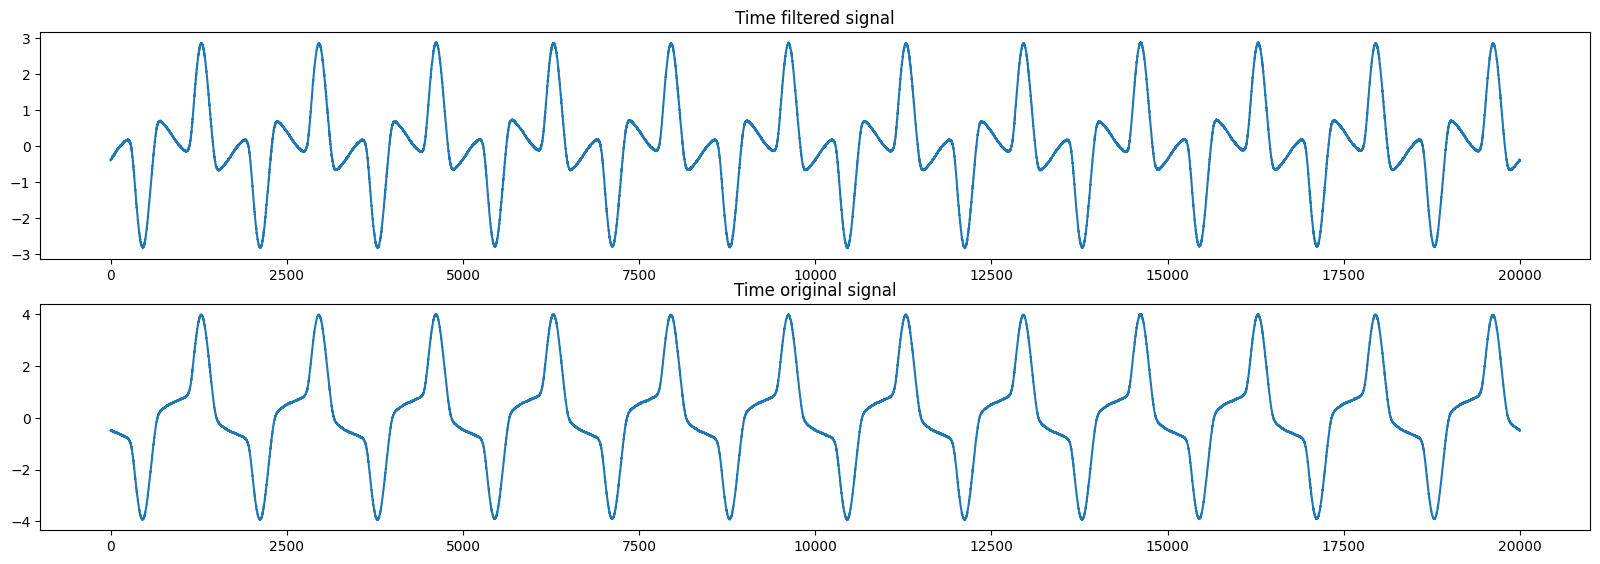

In [12]:
plt.figure(figsize=(20, 10))
plt.subplot(3,1,1)
plt.plot(np.fft.ifft(df['fft_cut'][20]))
plt.title('Time filtered signal')
plt.subplot(3,1,2)
plt.plot(np.fft.ifft(df['fft'][20]))
plt.title('Time original signal')
plt.plot()
plt.show()

## Create database for training

In [427]:
np.random.seed(42)
N = 5*60

freqs = np.fft.fftfreq(len(df['time_sig'][0]), fs) #list of ffrequences

list_train_signal = []
labels = df['label'].unique()
feature_size = len(df['time_sig'][0])
min_nb_labels = df['label'].value_counts().min()
dict_counter = {label:0 for label in labels}

for i in range(N):
    random_selection = np.random.randint(0,2, len(labels))
    mix = np.zeros(feature_size)
    present_labels = np.zeros(labels.shape)
    for i,label in enumerate(labels):
        if random_selection[i] == 1:
            mix += df['time_sig'][df['label']==label].iloc[np.random.randint(0, min_nb_labels)]
            present_labels[i] = 1
            dict_counter[label] += 1
    
    ft =np.fft.fft(mix)
    fc_low = 57 #Hz
    fc_high = 63 #Hz
    w = np.zeros(len(freqs))
    w[np.where(fc_high<freqs)] = 1
    w[np.where(freqs<fc_low)] = 1
    ft_cut =  ft*w
    abs_ft_cut_norm = abs(ft_cut/(np.linalg.norm(ft_cut) + 1e-10))
    h_index = np.where(freqs % 60 == 0)[0]
    harmo = np.log(abs_ft_cut_norm[h_index][2:n_harmonics] + 1e-10)
    if np.isnan(harmo).any(): print(np.isnan(harmo).sum())
    list_train_signal.append({'time_sig': mix, 'harmonics' : harmo ,'label': present_labels})

df_train = pd.DataFrame(list_train_signal)
df_train.head(5)

,time_sig,harmonics,label
0,"[-0.5449196319529874, -0.33242212454698084, -0...","[-6.752310132315143, -0.8984880582134991, -7.5...","[0.0, 1.0, 0.0, 0.0, 0.0]"
1,"[-2.6463266880338607, -2.098153779083931, -2.1...","[-5.55302912437299, -2.962083252443457, -6.067...","[0.0, 0.0, 0.0, 1.0, 0.0]"
2,"[-3.662561875830044, -4.616715311842735, -3.81...","[-1.6128185351234412, -3.845157792383845, -3.1...","[0.0, 0.0, 1.0, 0.0, 1.0]"
3,"[-4.517149485978003, -4.4825734161447155, -4.4...","[-6.5767544013509225, -1.8374279015554666, -7....","[0.0, 1.0, 0.0, 1.0, 1.0]"
4,"[-4.9489672067865635, -4.9893525299715265, -5....","[-1.8381651209193273, -1.7680494715007797, -3....","[1.0, 1.0, 1.0, 0.0, 0.0]"


Text(0.5, 1.0, 'Signal captured : \n Fun + hairdryer + lightbulb')

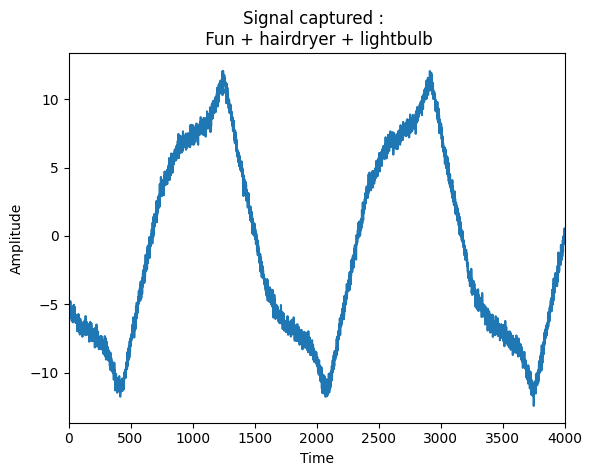

In [469]:
plt.plot(df_train['time_sig'][21])
xlim = plt.xlim(0, 4000)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal captured : \n Fun + hairdryer + lightbulb')

In [467]:
df_train['label'].iloc[21]

array([1., 1., 0., 1., 0.])

# train test split

In [430]:
from sklearn.model_selection import train_test_split
feature = 'harmonics'
feature_size = len(df_train[feature][0])
X= np.array(df_train[feature].tolist())
y = np.array(df_train['label'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)

(210, 198)
(210, 5)


# Multi logistic regressions

[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1.]
[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1.]
accuracy for Fun = 1.0
[1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
[1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0.
 1. 1.

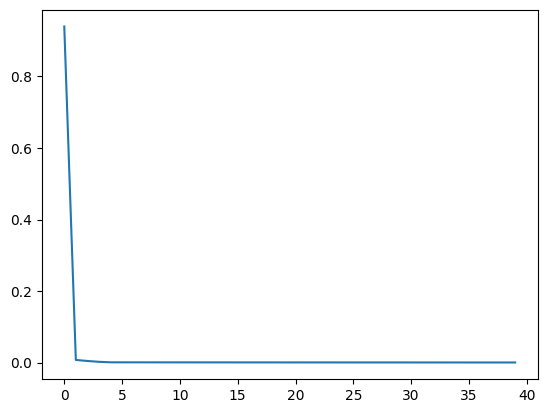

In [453]:
#buidling the model
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

pca = PCA(n_components=40)



avg_acc = 0
for i,label in enumerate(labels):
    y_label = y[:,i]
    X_pca = pca.fit_transform(np.array(df_train[feature].tolist()))
    Xtrain, Xtest, ytrain, ytest = train_test_split( X_pca, y_label, test_size=0.3, random_state=42)
    model = LogisticRegression()
    model.fit(Xtrain, ytrain)
    if i == 4:
        eigen_values = pca.explained_variance_ratio_


    ypred = model.predict(Xtest)
    print(ypred)
    print(ytest)
    avg_acc += accuracy_score(ytest, ypred)
    print(f'accuracy for {label} = {accuracy_score(ytest, ypred)}')

print(f'average accuracy = {avg_acc/len(labels)}')
plt.plot(eigen_values)



# Convolution 1D

In [215]:
import keras.backend as K
def rmse(predictions, targets):
    return K.sqrt(K.mean((predictions-targets)**2))

In [448]:
# convolution 1d network
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten


model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(feature_size,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(feature_size,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(feature_size,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(5, activation='sigmoid'))

model.compile(loss=rmse, optimizer='adam', metrics=['accuracy', rmse])
model.summary()

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_136 (Conv1D)         (None, 196, 32)           128       
                                                                 
 max_pooling1d_131 (MaxPooli  (None, 98, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_137 (Conv1D)         (None, 96, 64)            6208      
                                                                 
 max_pooling1d_132 (MaxPooli  (None, 48, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_138 (Conv1D)         (None, 46, 128)           24704     
                                                                 
 max_pooling1d_133 (MaxPooli  (None, 23, 128)        

Epoch 1/10
7/7 [==============================] - 2s 83ms/step - loss: 0.5201 - accuracy: 0.1952 - rmse: 0.5183 - val_loss: 0.5144 - val_accuracy: 0.0444 - val_rmse: 0.5147
Epoch 2/10
7/7 [==============================] - 1s 101ms/step - loss: 0.5091 - accuracy: 0.0143 - rmse: 0.5085 - val_loss: 0.5000 - val_accuracy: 0.2778 - val_rmse: 0.5002
Epoch 3/10
7/7 [==============================] - 0s 48ms/step - loss: 0.5005 - accuracy: 0.2571 - rmse: 0.5003 - val_loss: 0.4981 - val_accuracy: 0.2778 - val_rmse: 0.4981
Epoch 4/10
7/7 [==============================] - 0s 42ms/step - loss: 0.4965 - accuracy: 0.3286 - rmse: 0.4963 - val_loss: 0.4946 - val_accuracy: 0.3444 - val_rmse: 0.4944
Epoch 5/10
7/7 [==============================] - 1s 98ms/step - loss: 0.4926 - accuracy: 0.4952 - rmse: 0.4926 - val_loss: 0.4904 - val_accuracy: 0.3222 - val_rmse: 0.4902
Epoch 6/10
7/7 [==============================] - 0s 37ms/step - loss: 0.4866 - accuracy: 0.3143 - rmse: 0.4868 - val_loss: 0.4868 - v

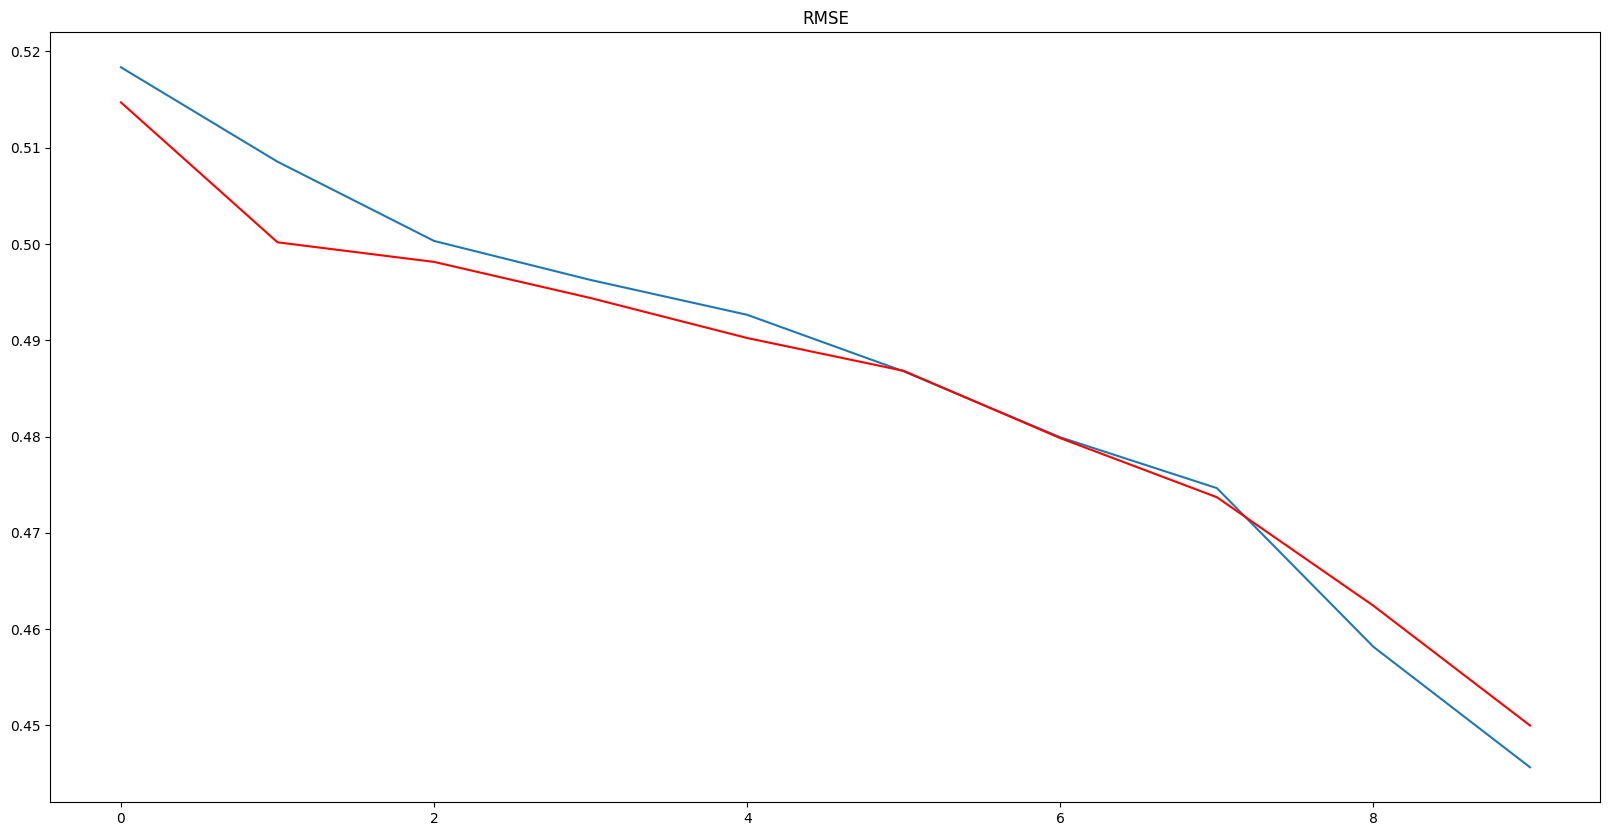

In [449]:
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test))
plt.figure(figsize=(20,10))
plt.title('RMSE')
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'], c='r')
avg = 0
ypred = model.predict(X_test)
for i,label in enumerate(labels):
    ypred_label = ypred[:,i].round()
    ytest_label = y_test[:,i]
    print(f'accuracy for {label} = {accuracy_score(ytest_label, ypred_label)}')
    avg += accuracy_score(ytest_label, ypred_label)
print(f'average accuracy = {avg/len(labels)}')
    

# SVM 

In [446]:
#svm model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


avg_acc = 0
for i,label in enumerate(labels):
    y_train_label = y_train[:,i]
    model = SVC()
    model.fit(X_train, y_train_label)

    ypred = model.predict(X_test)
    print(ypred)
    print(y_test[:,i])
    avg_acc += accuracy_score(y_test[:,i], ypred)
    print(f'accuracy for {label} = {accuracy_score(y_test[:,i], ypred)}')

print(f'average accuracy = {avg_acc/len(labels)}')

[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1.]
[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1.]
accuracy for Fun = 0.9777777777777777
[1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1.]
[1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 

## PCA

C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


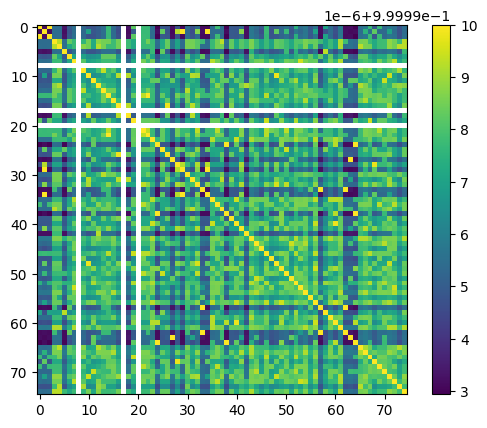

In [435]:
x = df_train['AFFTN'].tolist()
y = df_train['label'].tolist()
x = np.array(x)
#correlation matrix
x_corr = np.corrcoef(x)

plt.imshow(x_corr)
plt.colorbar()
plt.show()

In [437]:
principalComponents.shape

(75, 2)

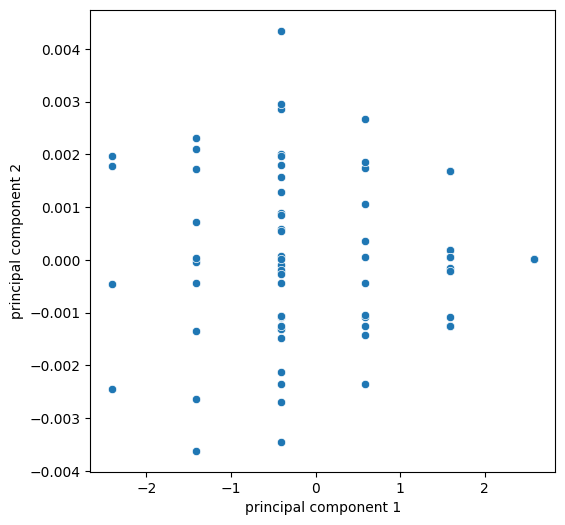

In [441]:
#apply PCA to fft column
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(df_train['AFFTN'].tolist()))

#plot PCA
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

plt.figure(figsize=(6,6))
sns.scatterplot(x=principalDf['principal component 1'], y=principalDf['principal component 2']) 
#save figure
plt.savefig('pca.png')  
plt.show()

In [88]:
print(mat['tpd'][0].dtype)

[('Name', 'O'), ('DateTime', 'O'), ('RangeMin', 'O'), ('RangeMax', 'O'), ('SampleFrequency', 'O'), ('PreSampleCount', 'O'), ('StartValue', 'O'), ('Unit', 'O'), ('Data', 'O')]


In [80]:
print(mat['tpd']['Data'][0][0][0])

[-2.0068629 -2.0049021 -2.0215688 ... -1.9588237 -2.0078433 -1.9941177]
